# 📊📚 Analysez des données de systèmes éducatifs

## Sommaire
[Introduction](#Introduction)  

[1. Librairies et chargement des data](#1.-Librairies-et-chargement-des-data)
- [a. Librairies importées](#a.-Librairies-importées)
- [b. Chargement des fichiers CSV](#b.-Chargement-des-fichiers-CSV)

[2. Nettoyage des dataframes](#2.-Nettoyage-des-dataframes)
- [a. Création du log df](#a.-Création-du-log-df)
- [b. Suppression des colonnes avec na_rate = 1](#b.-Suppression-des-colonnes-avec-na_rate-=-1)
- [c. Suppression des faux pays](#c.-Suppression-des-faux-pays)

[3. Sélection provisoire des indicateurs](#3.-Sélection-provisoire-des-indicateurs)
- [a. Indicateurs](#a.-Indicateurs)
-
-

## Introduction

Academy est une plateforme d'éducation en ligne pour les étudiants du niveau lycée et université.
La start-up qui a développé la plateforme souhaite l'étendre à un niveau internationnal. 

Pour ce faire, il faut dans un premier temps **s'assurer que les données récoltées de la banque mondiale sont exploitables** pour enrichir la réflexion. 
Puis, dans un second temps, **identifier les pays cibles avec un fort potentiel** et voir leur évolution dans le temps.

### 1. Librairies et chargement des data

#### a. Librairies importées

In [39]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#### b. Chargement des fichiers CSV

In [40]:
df_data = pd.read_csv('../dataset/EdStatsData.csv')
df_country_series = pd.read_csv('../dataset/EdStatsCountry-Series.csv')
df_country = pd.read_csv('../dataset/EdStatsCountry.csv')
df_foot_note = pd.read_csv('../dataset/EdStatsFootNote.csv')
df_stats_series = pd.read_csv('../dataset/EdStatsSeries.csv')

###### Description des DF

**df_data** : Ensemble des indicateurs par pays et par années (1970 à 2100). Chaque ligne représente le couple pays/indicateurs.

**df_country** : Liste d'informations complémentaires concernant les pays. Chaque ligne correspond à un pays.

**df_country_series** : Indicateurs démographiques et économiques par année et par pays présents dans df_data. Chaque ligne repésente le couples pays/indicateurs/années.

**df_stats_series** : Lexique des indicateurs. Chaque lique correspond à un indicateur.

**df_foot_note** : Informations additionnelles sur les indicateurs basées sur l'année, le type d'indicateur et le pays dans df_data.

In [41]:
#add widget to display df.head(5)

### 2. Nettoyage des dataframes

#### a. Création du log df 

In [42]:
#Log df infos
dic = {"df_data" : df_data, "df_country":df_country, "df_country_series" : df_country_series, 
           "df_foot_note" : df_foot_note, "df_stats_series" : df_stats_series}


cat_log = ['shape','duplicated_rows','na_rate', 'stats','nunique_cat']

obj_log = {
    'log_cat': cat_log,
    "df_data": [None] * len(cat_log),
    "df_country": [None] * len(cat_log),
    "df_country_series": [None] * len(cat_log),
    "df_foot_note": [None] * len(cat_log),
    "df_stats_series": [None] * len(cat_log)
}

df_log = pd.DataFrame(obj_log)

In [43]:
dic_keys = list(dic.keys())

for df_name in dic_keys:
    
    #Shape
    shape_value = dic[df_name].shape
    df_log.loc[df_log['log_cat'] == 'shape', df_name] = [shape_value]
    
    #duplicated_rows
    duplicates = dic[df_name].duplicated().sum()
    df_log.loc[df_log['log_cat'] == 'duplicated_rows', df_name] = [duplicates]
    
    #na_rate
    na_rate = round(dic[df_name].isna().sum() / len(dic[df_name]),2)
    df_log.loc[df_log['log_cat'] == 'na_rate', df_name] = [na_rate]
    
    #stats df.describe(include=[np.number])
    stats_report = dic[df_name].describe(include=[np.number])
    df_log.loc[df_log['log_cat'] == 'stats', df_name] = [stats_report]
    
    #Nb uniques categories df_obj = df.select_dtypes(include='object')
    unique_categories = dic[df_name].select_dtypes(include='object').nunique()
    df_log.loc[df_log['log_cat'] == 'nunique_cat', df_name] = [unique_categories]

In [44]:
df_log

,log_cat,df_data,df_country,df_country_series,df_foot_note,df_stats_series
0,shape,"(886930, 70)","(241, 32)","(613, 4)","(643638, 5)","(3665, 21)"
1,duplicated_rows,0,0,0,0,0
2,na_rate,Country Name 0.00 Country Code 0.00 ...,Country Code ...,CountryCode 0.0 SeriesCode 0.0 DESCRIPT...,CountryCode 0.0 SeriesCode 0.0 Year ...,Series Code 0.00 To...
3,stats,1970 1971 197...,National accounts reference year Lates...,Unnamed: 3 count 0.0 mean ...,Unnamed: 4 count 0.0 mean ...,Unit of measure Notes from original so...
4,nunique_cat,Country Name 242 Country Code 242 ...,Country Code ...,CountryCode 211 SeriesCode 21 DESCRIPT...,CountryCode 239 SeriesCode 1558 Year ...,Series Code 3665 To...


In [45]:
# Widgets : Toggle pour log_cat et Toggle pour les colonnes
toggle_cat = widgets.ToggleButtons(
    options=df_log['log_cat'].values,
    description='Category:',
    button_style=''
)

toggle_df = widgets.ToggleButtons(
    options=df_log.columns[1:],
    description='Dataframe:',
    button_style=''
)

# Output widget pour afficher le résultat
out = widgets.Output()

# Callback qui combine les deux sélections
def update_value(change):
    category_name = toggle_cat.value
    df_name = toggle_df.value
    
    with out:
        out.clear_output()
        try:
            valeur = df_log.loc[df_log['log_cat'] == category_name, df_name].iloc[0]
            
            if isinstance(valeur, pd.Series):
                display(valeur.to_frame())
            else:
                display(valeur)
                
        except Exception as e:
            print("Erreur :", e)

# Observer les changements sur les deux widgets
toggle_cat.observe(update_value, names='value')
toggle_df.observe(update_value, names='value')

# Affichage
display(toggle_cat, toggle_df, out)

ToggleButtons(description='Category:', options=('shape', 'duplicated_rows', 'na_rate', 'stats', 'nunique_cat')…

ToggleButtons(description='Dataframe:', options=('df_data', 'df_country', 'df_country_series', 'df_foot_note',…

Output()

#### b. Suppression des colonnes avec na_rate = 1

In [46]:
if df_data.loc[:,['Country Name','Indicator Name']].duplicated().sum() == 0:
    print('✅ Pas de doublon pour le couple Pays/Indicateurs dans le df_data')

✅ Pas de doublon pour le couple Pays/Indicateurs dans le df_data


In [47]:
col_to_delete = []

for df_name in dic_keys:
    temp_df = df_log.loc[df_log['log_cat'] == "na_rate", df_name].iloc[0].reset_index()
    
    #col name
    new_col_name = ['col_name','na_rate']
    temp_df.columns = new_col_name
    temp_df_filtered = temp_df[temp_df['na_rate'] == 1]
    col_list = temp_df_filtered['col_name'].astype(str).tolist()
    
    for col in col_list:
        col_to_delete.append(col)

print(col_to_delete)

['2017', 'Unnamed: 69', 'Unnamed: 31', 'Unnamed: 3', 'Unnamed: 4', 'Unit of measure', 'Limitations and exceptions', 'Notes from original source', 'General comments', 'Development relevance', 'Other web links', 'Related indicators', 'License Type', 'Unnamed: 20']


In [48]:
col_to_delete_set = set(col_to_delete)

for df_name in dic_keys:
    col_to_keep = [x for x in dic[df_name].columns if x not in col_to_delete_set]
    dic[df_name] = dic[df_name][col_to_keep]

### c. Suppression des faux pays

In [49]:
#from df_country['Short Name'].unique()
region_to_delete = ['Arab World','East Asia & Pacific (developing only)',
       'East Asia & Pacific (all income levels)',
       'Europe & Central Asia (developing only)',
       'Europe & Central Asia (all income levels)','Euro area','European Union','High income',
       'Heavily indebted poor countries (HIPC)','Latin America & Caribbean (developing only)',
       'Latin America & Caribbean (all income levels)',
       'Least developed countries: UN classification', 'Low income','Lower middle income',
       'Low & middle income','Middle East & North Africa (all income levels)','Middle income',
       'OECD members','Sub-Saharan Africa (developing only)','Sub-Saharan Africa (all income levels)',
       'Middle East & North Africa (developing only)',
       'World','Latin America & Caribbean',
       'Middle East & North Africa (excluding high income)',
       'North America', 'South Asia', 'Upper middle income',]

In [50]:
df_region = df_country[df_country['Short Name'].isin(region_to_delete)]
df_region = df_region.loc[:,['Short Name','Country Code']]

In [51]:
dic['df_country_series'] = dic['df_country_series'].rename(columns={'CountryCode' : 'Country Code'})
dic['df_foot_note'] = dic['df_foot_note'].rename(columns={'CountryCode' : 'Country Code'})

In [52]:
for df_name in dic_keys:
    if df_name != 'df_stats_series':
        dic[df_name] = dic[df_name][~dic[df_name]['Country Code'].isin(df_region['Country Code'].unique())]

## 3. Sélection provisoire des indicateurs

#### a. Indicateurs

#### Critères de recherches. 

il faudrait que les pays :

 - aient une accessibilité restreinte du niveau secondaire et universitaire. Soit par:
     - un manque d'infrasturcture
     - un manque de personnel
     - réservé à une certaine population (classe sociale, genre...).
 - aient une population jeune avec une demande forte pour léducation (% de diplômé faible par rapport à la population en âge de l'être).
 - soient un minimum développé de sorte à ce que les étudiants puissent se procurer le matériel informatique adéquat.

**Pourquoi ?** 

✅ Opportunité de proposer une alternative.

✅ Cette proposition est viable s'il y a de la demande.

✅ Et cette dernière doit avoir les moyens d'accéder au produit.

In [53]:
# Identification des indicateurs
dic_kpis = {
    'School accessibility': {
        'Teachers': [
            'Teachers in secondary education, both sexes (number)',
            'Teachers in tertiary education programmes, both sexes (number)',
        ],
        'Education Management Information Systems (SABER)': [
            'SABER: (Education Management Information Systems) Policy Goal 1 Lever 4: Infrastructural capacity'
        ],
        'Attainment': [
            'Barro-Lee: Percentage of population age 15+ with no education'
        ],
        'Education Equality': [
            #multiple data sources
            'MICS: Secondary completion rate. Female',
            'MICS: Secondary completion rate. Male',
            'MICS: Secondary completion rate. Rural',
            'MICS: Secondary completion rate. Urban',
            'UIS: Total net attendance rate, lower secondary, female (%)',
            'UIS: Total net attendance rate, lower secondary, male (%)',
            'UIS: Total net attendance rate, lower secondary, rural, both sexes (%)',
            'UIS: Total net attendance rate, lower secondary, urban, both sexes (%)', 
        ]
    },
    'Demography': {
        'Population': [
            'Population of the official age for secondary education, both sexes (number)'
        ],
        'Health: Population: Structure': [
            'Population, total'
        ],
        'Health: Population: Dynamics': [
            'Population growth (annual %)'
        ]
    },
    'Technology': {
        'Infrastructure: Communications': [
            'Personal computers (per 100 people)',
            'Internet users (per 100 people)'
        ]
    }
}

#### b. Filtrage du df data

In [54]:
kpis_list = []
for theme in dic_kpis:
    for topic in dic_kpis[theme]:
        for kpi in dic_kpis[theme][topic]:
            kpis_list.append(kpi)

df_data_filtered = dic['df_data'][dic['df_data']['Indicator Name'].isin(kpis_list)]

#### c. Sélection des années

In [55]:
years_to_keep = ['2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2020', '2025', '2030']
df_data_filtered_years = df_data_filtered.loc[:,['Country Name','Country Code','Indicator Name','Indicator Code'] + years_to_keep]

In [56]:
kpis_na_rate = df_data_filtered_years.groupby(
    ['Indicator Name']
)[years_to_keep].apply(lambda g: g.isna().mean()).reset_index().transpose()

kpis_na_rate_col = list(kpis_na_rate.iloc[0].values)

kpis_na_rate.columns = kpis_na_rate_col

kpis_na_rate = kpis_na_rate.iloc[1:]
kpis_na_rate = kpis_na_rate.reset_index()

In [57]:
kpis_na_rate

,index,Barro-Lee: Percentage of population age 15+ with no education,Internet users (per 100 people),MICS: Secondary completion rate. Female,MICS: Secondary completion rate. Male,MICS: Secondary completion rate. Rural,MICS: Secondary completion rate. Urban,Personal computers (per 100 people),Population growth (annual %),"Population of the official age for secondary education, both sexes (number)","Population, total",SABER: (Education Management Information Systems) Policy Goal 1 Lever 4: Infrastructural capacity,"Teachers in secondary education, both sexes (number)","Teachers in tertiary education programmes, both sexes (number)","UIS: Total net attendance rate, lower secondary, female (%)","UIS: Total net attendance rate, lower secondary, male (%)","UIS: Total net attendance rate, lower secondary, rural, both sexes (%)","UIS: Total net attendance rate, lower secondary, urban, both sexes (%)"
0,2000,0.336406,0.096774,1.0,1.0,1.0,1.0,0.253456,0.009217,0.124424,0.009217,1.0,0.474654,0.497696,0.990783,0.990783,0.990783,0.990783
1,2001,1.0,0.092166,1.0,1.0,1.0,1.0,0.16129,0.009217,0.115207,0.009217,1.0,0.470046,0.525346,0.995392,0.995392,0.995392,0.995392
2,2002,1.0,0.082949,1.0,1.0,1.0,1.0,0.16129,0.009217,0.105991,0.009217,1.0,0.488479,0.516129,1.0,1.0,1.0,1.0
3,2003,1.0,0.110599,1.0,1.0,1.0,1.0,0.175115,0.009217,0.105991,0.009217,1.0,0.488479,0.543779,0.97235,0.97235,0.97235,0.97235
4,2004,1.0,0.096774,1.0,1.0,1.0,1.0,0.175115,0.009217,0.105991,0.009217,1.0,0.483871,0.539171,0.967742,0.967742,0.967742,0.967742
5,2005,0.336406,0.087558,0.963134,0.963134,0.963134,0.963134,0.211982,0.009217,0.105991,0.009217,1.0,0.497696,0.580645,0.9447,0.9447,0.9447,0.9447
6,2006,1.0,0.092166,0.963134,0.963134,0.97235,0.97235,0.543779,0.009217,0.105991,0.009217,1.0,0.506912,0.576037,0.870968,0.870968,0.870968,0.870968
7,2007,1.0,0.059908,0.995392,0.995392,0.995392,0.995392,0.778802,0.009217,0.101382,0.009217,1.0,0.474654,0.576037,0.9447,0.9447,0.9447,0.9447
8,2008,1.0,0.064516,1.0,1.0,1.0,1.0,0.875576,0.009217,0.101382,0.009217,1.0,0.520737,0.580645,0.967742,0.967742,0.967742,0.967742
9,2009,1.0,0.069124,1.0,1.0,1.0,1.0,0.986175,0.009217,0.096774,0.009217,1.0,0.511521,0.529954,0.963134,0.963134,0.963134,0.963134


## 4. Sélection définitive des indicateurs

#### a. Indicateurs définitifs

In [58]:
# Identification des indicateurs
dic_kpis = {
    'School accessibility': {
        'Teachers': [
            'Teachers in secondary education, both sexes (number)',
            'Teachers in tertiary education programmes, both sexes (number)',
        ],
        'Attainment': [
            'Barro-Lee: Percentage of population age 15+ with no education'
        ],
},
    'Demography': {
        'Population': [
            'Population of the official age for secondary education, both sexes (number)',
            'Population of the official age for tertiary education, both sexes (number)'
        ],
        'Health: Population: Structure': [
            'Population, total'
        ],
        'Health: Population: Dynamics': [
            'Population growth (annual %)'
        ]
    },
    'Technology': {
        'Infrastructure: Communications': [
            'Personal computers (per 100 people)',
            'Internet users (per 100 people)'
        ]
    }
}

#### b. Filtrage du df data

In [59]:
kpis_list = []
for theme in dic_kpis:
    for topic in dic_kpis[theme]:
        for kpi in dic_kpis[theme][topic]:
            kpis_list.append(kpi)

df_data_filtered = dic['df_data'][dic['df_data']['Indicator Name'].isin(kpis_list)]

In [60]:
kpis_na_rate = df_data_filtered.groupby(
    ['Indicator Name']
)[years_to_keep].apply(lambda g: g.isna().mean()).reset_index().transpose()

kpis_na_rate_col = list(kpis_na_rate.iloc[0].values)

kpis_na_rate.columns = kpis_na_rate_col

kpis_na_rate = kpis_na_rate.iloc[1:]

In [61]:
kpis_na_rate = kpis_na_rate.reset_index()
kpis_na_rate = kpis_na_rate.sort_values(by=['index'], ascending=False)

In [62]:
kpis_na_rate

,index,Barro-Lee: Percentage of population age 15+ with no education,Internet users (per 100 people),Personal computers (per 100 people),Population growth (annual %),"Population of the official age for secondary education, both sexes (number)","Population of the official age for tertiary education, both sexes (number)","Population, total","Teachers in secondary education, both sexes (number)","Teachers in tertiary education programmes, both sexes (number)"
19,2030,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
18,2025,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
17,2020,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
16,2016,1.0,0.073733,1.0,0.032258,0.271889,0.967742,0.032258,0.963134,0.97235
15,2015,1.0,0.073733,1.0,0.032258,0.101382,0.40553,0.032258,0.552995,0.635945
14,2014,1.0,0.073733,1.0,0.032258,0.096774,0.101382,0.032258,0.479263,0.539171
13,2013,1.0,0.073733,1.0,0.013825,0.101382,0.248848,0.013825,0.520737,0.525346
12,2012,1.0,0.069124,1.0,0.013825,0.101382,0.221198,0.013825,0.529954,0.502304
11,2011,1.0,0.059908,1.0,0.013825,0.101382,0.193548,0.009217,0.497696,0.506912
10,2010,0.336406,0.069124,1.0,0.009217,0.105991,0.115207,0.009217,0.548387,0.543779


#### c. Sélection des années

In [63]:
list_kpi_year = []
for col in kpis_list:
    minus = kpis_na_rate[col].min()
    year = kpis_na_rate.where(kpis_na_rate[col] == minus)['index'].unique().astype(float)
    year = year[np.where(~np.isnan(year))]
    list_kpi_year.append(year[0])

In [64]:
df_kpis_year_selection = pd.DataFrame(columns=kpis_list)
df_kpis_year_selection.loc[0] = list_kpi_year

for col in df_kpis_year_selection.columns:
    df_kpis_year_selection[col] = df_kpis_year_selection[col].astype(int)
    df_kpis_year_selection[col] = df_kpis_year_selection[col].astype(str)

In [65]:
df_kpis_year_selection

,"Teachers in secondary education, both sexes (number)","Teachers in tertiary education programmes, both sexes (number)",Barro-Lee: Percentage of population age 15+ with no education,"Population of the official age for secondary education, both sexes (number)","Population of the official age for tertiary education, both sexes (number)","Population, total",Population growth (annual %),Personal computers (per 100 people),Internet users (per 100 people)
0,2001,2000,2010,2014,2002,2011,2010,2002,2011


In [66]:
df_data_final = df_data_filtered.loc[:,['Country Name','Country Code']].drop_duplicates()

for kpi in kpis_list:
    temp_df = df_data_filtered[df_data_filtered['Indicator Name'] == kpi]
    year = df_kpis_year_selection[kpi].values
    temp_df = temp_df.loc[:,['Country Code', year[0]]]
    temp_df = temp_df.rename(columns={year[0] : kpi})
    df_data_final = pd.merge(df_data_final, temp_df, how='left', on='Country Code')

#### d. Normalisation des données

In [67]:
df_data_final['Teachers'] = df_data_final['Teachers in secondary education, both sexes (number)'] + df_data_final['Teachers in tertiary education programmes, both sexes (number)']

df_data_final['Potential students'] = df_data_final['Population of the official age for secondary education, both sexes (number)'] + df_data_final['Population of the official age for tertiary education, both sexes (number)']

In [68]:
df_data_final['Teachers (per 100 students)'] = round(df_data_final['Teachers']  /
                                                     df_data_final['Potential students'] * 100,2)

In [69]:
df_data_final['Students (per 100 people)'] = round(df_data_final['Potential students'] /
                                                            df_data_final['Population, total'] * 100,2)

In [70]:
df_data_final = df_data_final.dropna()
df_data_final = df_data_final.loc[:,['Country Name','Population, total','Barro-Lee: Percentage of population age 15+ with no education','Population growth (annual %)',
                                    'Personal computers (per 100 people)','Internet users (per 100 people)','Teachers (per 100 students)','Students (per 100 people)']]

In [71]:
df_data_final.head(5)

,Country Name,"Population, total",Barro-Lee: Percentage of population age 15+ with no education,Population growth (annual %),Personal computers (per 100 people),Internet users (per 100 people),Teachers (per 100 students),Students (per 100 people)
1,Albania,2905195.0,3.28,-0.496462,1.103078,49.000000,4.19,20.73
7,Argentina,41656879.0,0.93,1.035037,7.972883,51.000000,4.53,17.82
15,Bangladesh,153911916.0,31.88,1.119888,0.328452,4.500000,0.87,23.94
16,Barbados,280601.0,0.22,0.393880,10.388685,66.500000,4.81,13.89
18,Belgium,11047744.0,4.67,0.913639,27.082004,81.609996,9.71,12.27


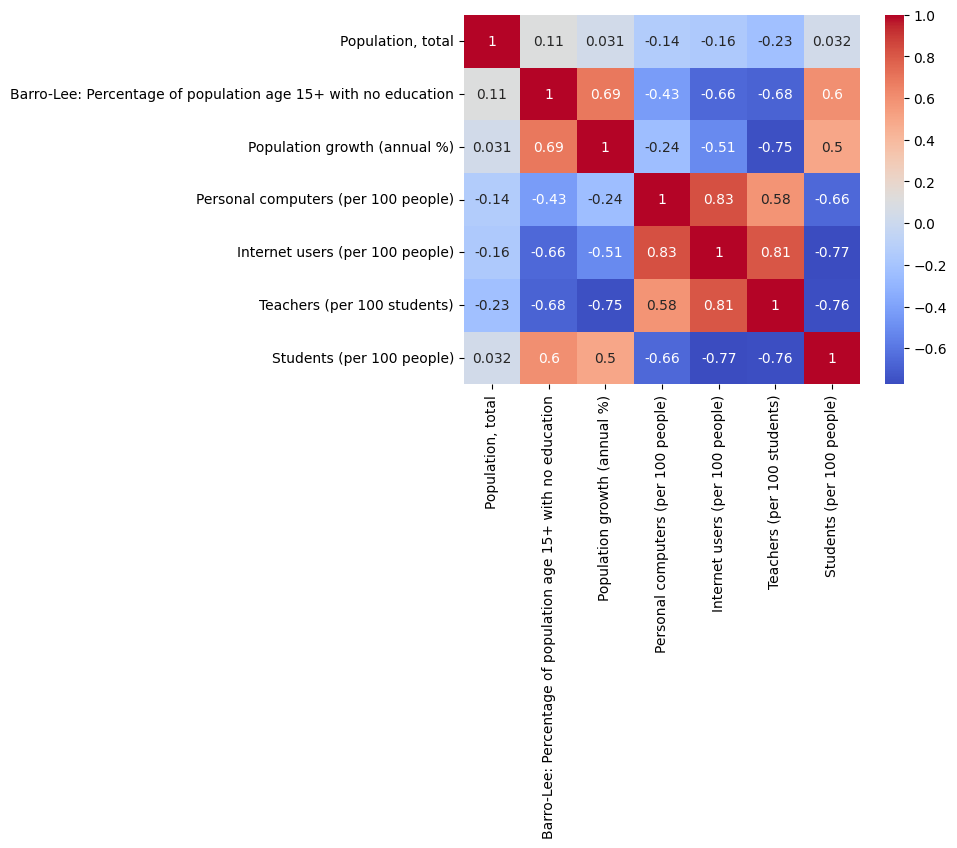

In [72]:
corr = df_data_final.drop(columns=['Country Name']).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

In [73]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_data_final.drop(columns=['Country Name','Population, total']))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Variance expliquée :", pca.explained_variance_ratio_)

Variance expliquée : [0.69900368 0.15703918]


**Variance expliquée**

En supprimant la colonne "Population totale", environ 85% de la variance est expliquée avec deux composantes seulement.
PC1 étant à 69,9% ce qui est très élevé et cela en fait le facteur le plus important pour différencier les pays.

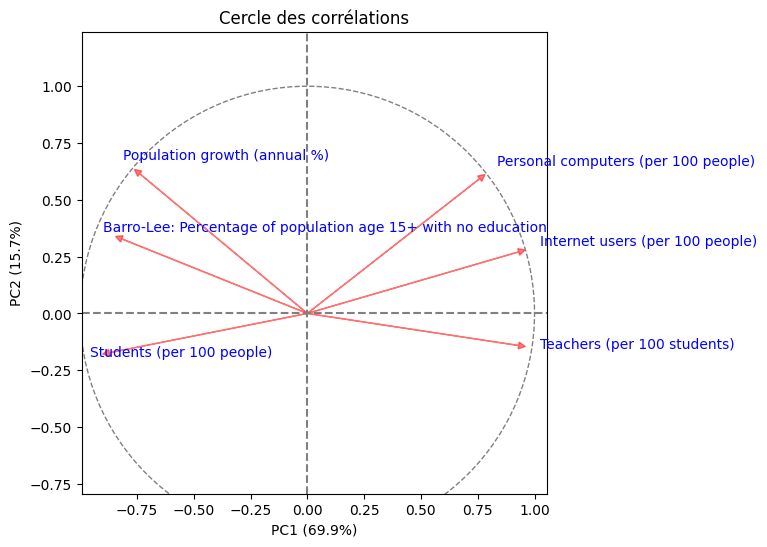

In [74]:
# Récupération des composantes
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Noms des variables
features = df_data_final.drop(columns=['Country Name','Population, total']).columns

# Tracer le cercle
plt.figure(figsize=(6,6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i,0], loadings[i,1],
              color='r', alpha=0.5, head_width=0.03, head_length=0.03)
    plt.text(loadings[i,0]*1.1, loadings[i,1]*1.1, feature, color='b')

# Cercle unité
circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Cercle des corrélations")
plt.axis('equal')
plt.show()

**PC1 69,9%**

- Les variables "teachers", "internet users" et "Personal computers" sont très fortement corrélées positivement avec PC1.
- Elles définissent clairement cet axe, qui peut être interprété comme un indicateur de développement technologique et d'accès à l'information.

**PC2 15,7%**

- Les variables "population growth" et "Barro-lee : % age 15+ with no education" sont fortement corrélées positiviement avec PC2.
- Cet axe peut être interprété comme un indicateur de croissance démographique et de faible niveau d'éducation.
- La variable "Students" est également liée à cet axe mais de mnaière plus faible.

**Interprétation des variables**

- "Personal computers" et "internet users", sont fortement liées. Intuitivement on comprend qu'un accès élevé aux ordinateurs va de pair avec une forte utilisation d'internet.

- "Population growth" et "Barro-lee : % age 15+ with no education" sont également liés, ce qui idnique que les pays avec une forte croissance démographique ont tendance à avoir une plus grande proportion de population non éduquée. 

- "Personal computers" et "internet users" sont opposés à "Population growth" et "Barro-lee : % age 15+ with no education", ce qui signifie que les pays avec un haut niveau d'équipement technologique et d'accès à internet ont une faible croissance démographique et une population plus éduquée.

- "Students" est également opposé à "Personal computers" et "internet users" ce qui montre qu'il n'y a pas de corrélation significative entre le nombre d'étudiants par habitant et le niveau technologique.


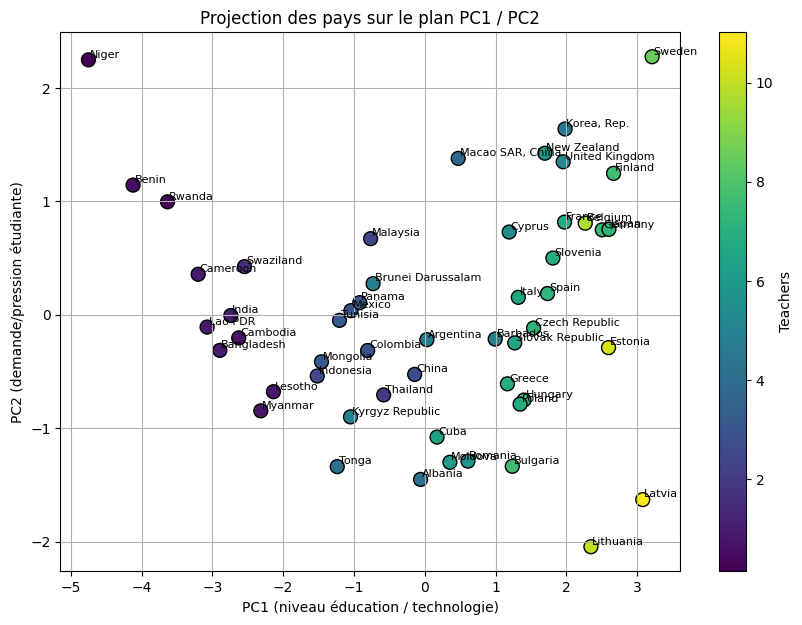

In [75]:
plt.figure(figsize=(10,7))

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Country'] = df_data_final['Country Name'].values
df_pca['Teachers (per 100 students)'] = df_data_final['Teachers (per 100 students)'].values 

# Scatter plot : PC1 vs PC2, couleur selon 'Teachers'
scatter = plt.scatter(
    df_pca['PC1'], 
    df_pca['PC2'], 
    c=df_pca['Teachers (per 100 students)'], 
    cmap='viridis',   
    s=100,            
    edgecolor='k'
)

plt.colorbar(scatter, label='Teachers')  # légende de la couleur
plt.xlabel('PC1 (niveau éducation / technologie)')
plt.ylabel('PC2 (demande/pression étudiante)')
plt.title('Projection des pays sur le plan PC1 / PC2')
plt.grid(True)


for i, country in enumerate(df_pca['Country']):
    plt.text(df_pca['PC1'][i]+0.02, df_pca['PC2'][i]+0.02, country, fontsize=8)

plt.show()